In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import ScaledQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 10

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RZRX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = ScaledQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(10000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:15<00:00, 632.32it/s]

32


In [9]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for params, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=ghz_circuit_gen.get_noisy_model_circuit_params(params))
        # print(ideal)
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.raw_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.raw_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    param_arr = np.array(param_list).transpose()
    print(param_arr)    
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 10000/10000 [01:49<00:00, 90.97it/s, Loss: 3207.5625] 


Loss: 9228.3753, Params: Parameter containing:
tensor([ 0.3161, -0.1267, -1.0955,  0.3017,  0.1854, -0.7898, -1.1236, -0.2573,
         0.4712,  1.0646], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.3161369   0.31613374
   0.31613058]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.12674694 -0.12674567
  -0.1267444 ]
 [-1.2108755  -1.2108634  -1.2108512  ... -1.0955353  -1.0955243
  -1.0955133 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.25729424 -0.25729167
  -0.2572891 ]
 [ 0.52078587  0.5207807   0.5207755  ...  0.47118363  0.47117892
   0.4711742 ]
 [ 1.1767117   1.1766999   1.1766881  ...  1.064611    1.0646003
   1.0645897 ]]
Starting Epoch 2


100%|██████████| 10000/10000 [02:00<00:00, 83.04it/s, Loss: 2406.1875] 


Loss: 8810.2115, Params: Parameter containing:
tensor([ 0.2860, -0.1147, -0.9911,  0.2730,  0.1678, -0.7146, -1.0165, -0.2328,
         0.4263,  0.9632], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.2860144   0.28601155
   0.2860087 ]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.11467005 -0.1146689
  -0.11466775]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.9911442  -0.9911342
  -0.9911243 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.23278025 -0.23277792
  -0.2327756 ]
 [ 0.52078587  0.5207807   0.5207755  ...  0.42628714  0.42628288
   0.42627862]
 [ 1.1767117   1.1766999   1.1766881  ...  0.9631804   0.96317077
   0.9631611 ]]
Starting Epoch 3


100%|██████████| 10000/10000 [02:03<00:00, 80.66it/s, Loss: 15465.8125]


Loss: 8320.2047, Params: Parameter containing:
tensor([ 0.2588, -0.1037, -0.8967,  0.2470,  0.1518, -0.6465, -0.9197, -0.2106,
         0.3857,  0.8714], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.25876188  0.2587593
   0.2587567 ]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.10374323 -0.1037422
  -0.10374116]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.8967041  -0.8966951
  -0.8966861 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.21059932 -0.2105972
  -0.21059509]
 [ 0.52078587  0.5207807   0.5207755  ...  0.38566685  0.38566297
   0.3856591 ]
 [ 1.1767117   1.1766999   1.1766881  ...  0.87140083  0.87139213
   0.8713834 ]]
Starting Epoch 4


100%|██████████| 10000/10000 [02:03<00:00, 81.04it/s, Loss: 16403.125]


Loss: 7773.3244, Params: Parameter containing:
tensor([ 0.2341, -0.0939, -0.8112,  0.2234,  0.1373, -0.5849, -0.8320, -0.1905,
         0.3489,  0.7884], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.2341054   0.23410305
   0.23410071]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.09385844 -0.0938575
  -0.09385657]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.8112619  -0.8112538
  -0.8112457 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.19053344 -0.19053154
  -0.19052963]
 [ 0.52078587  0.5207807   0.5207755  ...  0.34891972  0.34891623
   0.34891275]
 [ 1.1767117   1.1766999   1.1766881  ...  0.78836775  0.7883599
   0.788352  ]]
Starting Epoch 5


100%|██████████| 10000/10000 [02:05<00:00, 79.43it/s, Loss: 5560.375] 


Loss: 7157.9585, Params: Parameter containing:
tensor([ 0.2118, -0.0849, -0.7339,  0.2021,  0.1242, -0.5291, -0.7528, -0.1724,
         0.3157,  0.7132], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.2117985   0.21179639
   0.21179427]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.08491516 -0.08491431
  -0.08491346]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.7339603  -0.73395294
  -0.7339456 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.1723783  -0.17237657
  -0.17237484]
 [ 0.52078587  0.5207807   0.5207755  ...  0.31567356  0.3156704
   0.31566724]
 [ 1.1767117   1.1766999   1.1766881  ...  0.7132514   0.71324426
   0.7132371 ]]
Starting Epoch 6


100%|██████████| 10000/10000 [02:04<00:00, 80.29it/s, Loss: 1180.5625]


Loss: 6510.4783, Params: Parameter containing:
tensor([ 0.1916, -0.0768, -0.6640,  0.1829,  0.1124, -0.4787, -0.6810, -0.1560,
         0.2856,  0.6453], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.19161746  0.19161554
   0.19161361]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.07682387 -0.0768231
  -0.07682233]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.66402185 -0.6640152
  -0.6640085 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.15595317 -0.1559516
  -0.15595004]
 [ 0.52078587  0.5207807   0.5207755  ...  0.28559482  0.28559196
   0.2855891 ]
 [ 1.1767117   1.1766999   1.1766881  ...  0.64528567  0.6452792
   0.6452728 ]]
Starting Epoch 7


100%|██████████| 10000/10000 [02:02<00:00, 81.78it/s, Loss: 3138.9375]


Loss: 5839.9146, Params: Parameter containing:
tensor([ 0.1734, -0.0695, -0.6007,  0.1654,  0.1017, -0.4331, -0.6161, -0.1411,
         0.2584,  0.5838], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.17335793  0.1733562
   0.17335448]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.06950328 -0.06950259
  -0.0695019 ]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.60075533 -0.6007493
  -0.6007433 ]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.14109325 -0.14109184
  -0.14109042]
 [ 0.52078587  0.5207807   0.5207755  ...  0.2583816   0.258379
   0.25837642]
 [ 1.1767117   1.1766999   1.1766881  ...  0.5838039   0.58379805
   0.5837922 ]]
Starting Epoch 8


100%|██████████| 10000/10000 [02:08<00:00, 77.88it/s, Loss: 6674.625] 


Loss: 5183.9984, Params: Parameter containing:
tensor([ 0.1568, -0.0629, -0.5435,  0.1497,  0.0920, -0.3918, -0.5574, -0.1276,
         0.2338,  0.5282], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.15683988  0.15683831
   0.15683675]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.06288029 -0.06287966
  -0.06287903]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.5435098  -0.54350436
  -0.54349893]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.12764914 -0.12764786
  -0.12764658]
 [ 0.52078587  0.5207807   0.5207755  ...  0.23376223  0.2337599
   0.23375756]
 [ 1.1767117   1.1766999   1.1766881  ...  0.52817434  0.52816904
   0.52816373]]
Starting Epoch 9


100%|██████████| 10000/10000 [02:02<00:00, 81.74it/s, Loss: 5467.25]  


Loss: 4568.3648, Params: Parameter containing:
tensor([ 0.1419, -0.0569, -0.4917,  0.1354,  0.0832, -0.3545, -0.5043, -0.1155,
         0.2115,  0.4778], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.1418955   0.14189409
   0.14189267]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.05688966 -0.05688909
  -0.05688852]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.49172428 -0.49171937
  -0.49171445]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.11548636 -0.11548521
  -0.11548405]
 [ 0.52078587  0.5207807   0.5207755  ...  0.2114881   0.21148598
   0.21148387]
 [ 1.1767117   1.1766999   1.1766881  ...  0.47784787  0.47784308
   0.47783828]]
Starting Epoch 10


100%|██████████| 10000/10000 [02:00<00:00, 82.73it/s, Loss: 8912.3125]


Loss: 4004.5162, Params: Parameter containing:
tensor([ 0.1284, -0.0515, -0.4449,  0.1225,  0.0753, -0.3207, -0.4563, -0.1045,
         0.1913,  0.4323], requires_grad=True)
[[ 0.34942067  0.34941718  0.3494137  ...  0.12837538  0.1283741
   0.12837282]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.05146876 -0.05146825
  -0.05146774]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.44486836 -0.44486392
  -0.44485947]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.10448184 -0.1044808
  -0.10447975]
 [ 0.52078587  0.5207807   0.5207755  ...  0.19133548  0.19133356
   0.19133164]
 [ 1.1767117   1.1766999   1.1766881  ...  0.43231696  0.43231264
   0.43230832]]


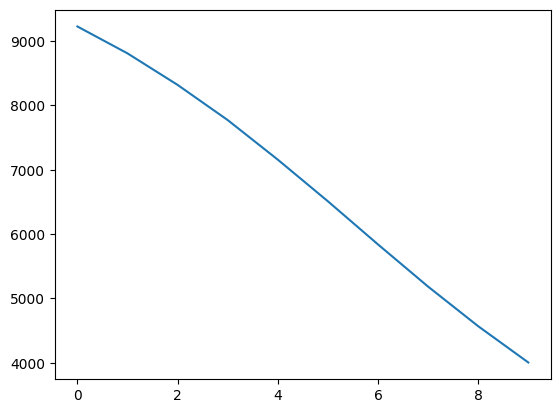

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[ 0.34942067  0.34941718  0.3494137  ...  0.12837538  0.1283741
   0.12837282]
 [-0.14009173 -0.14009033 -0.14008893 ... -0.05146876 -0.05146825
  -0.05146774]
 [-1.2108755  -1.2108634  -1.2108512  ... -0.44486836 -0.44486392
  -0.44485947]
 ...
 [-0.28438452 -0.28438166 -0.2843788  ... -0.10448184 -0.1044808
  -0.10447975]
 [ 0.52078587  0.5207807   0.5207755  ...  0.19133548  0.19133356
   0.19133164]
 [ 1.1767117   1.1766999   1.1766881  ...  0.43231696  0.43231264
   0.43230832]]


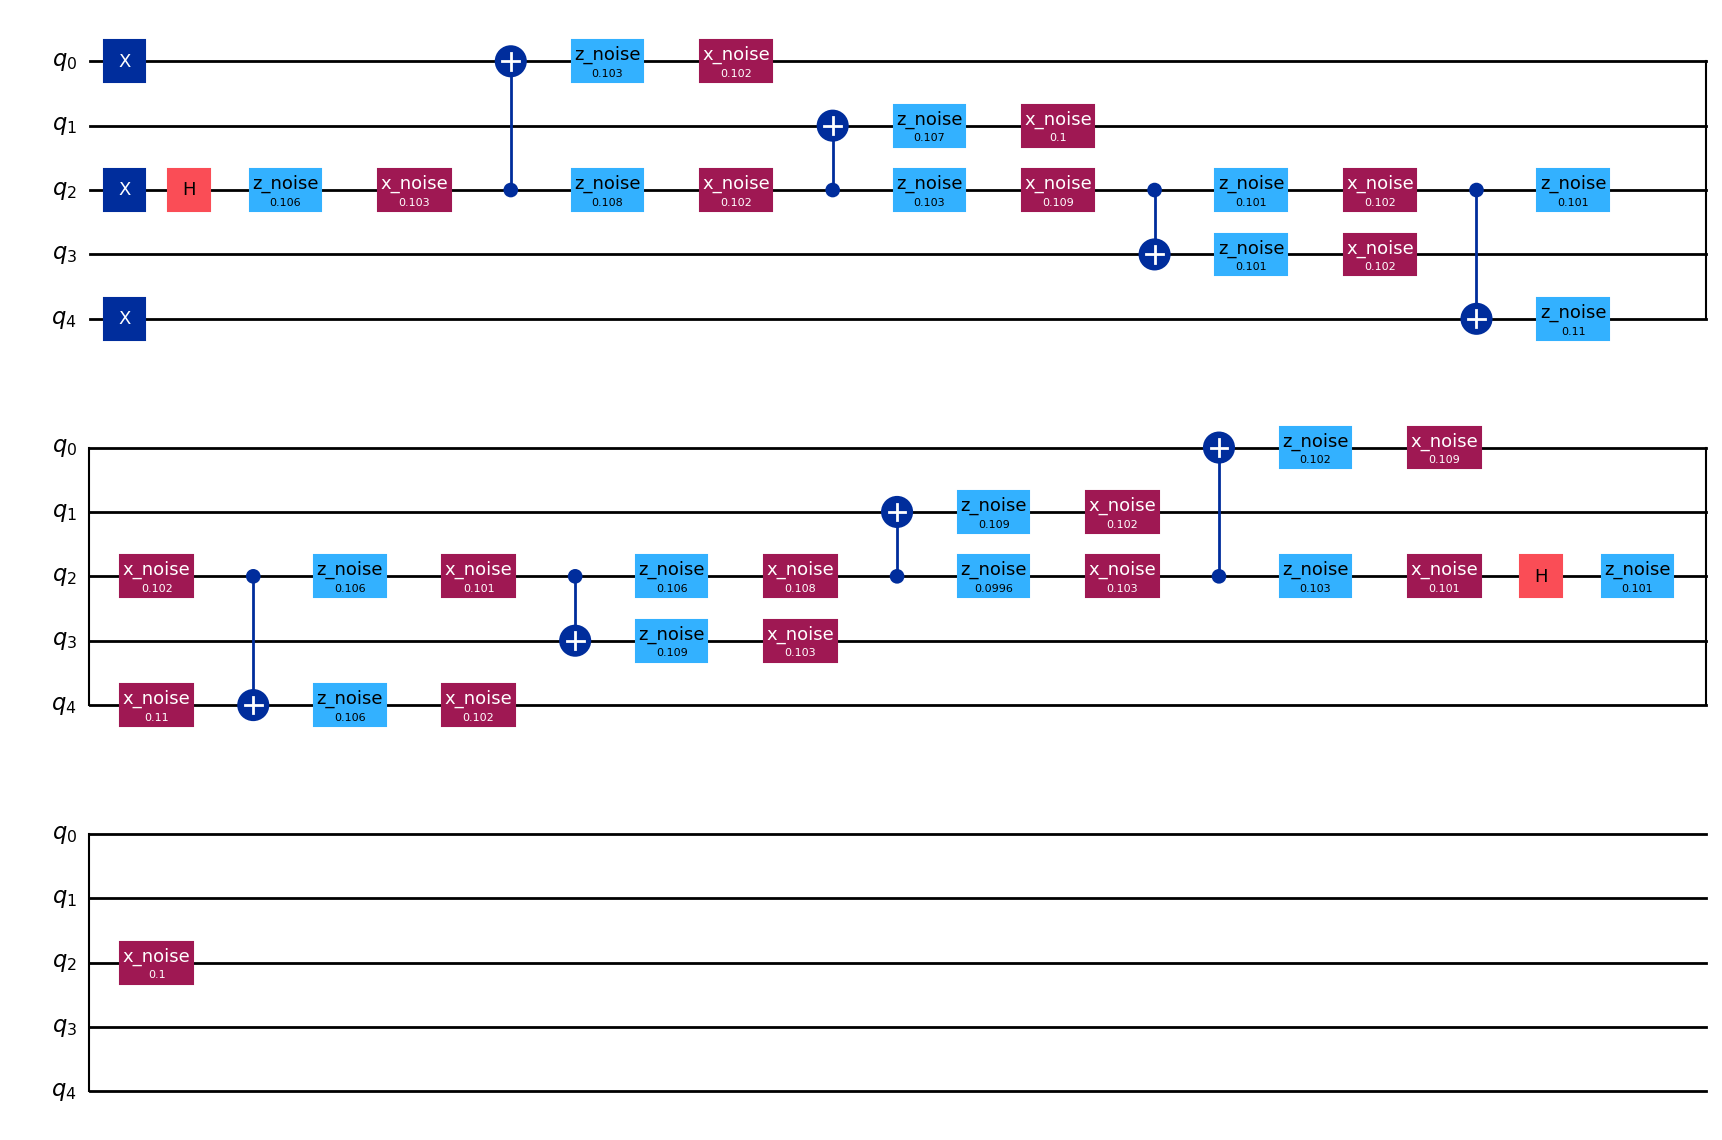

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

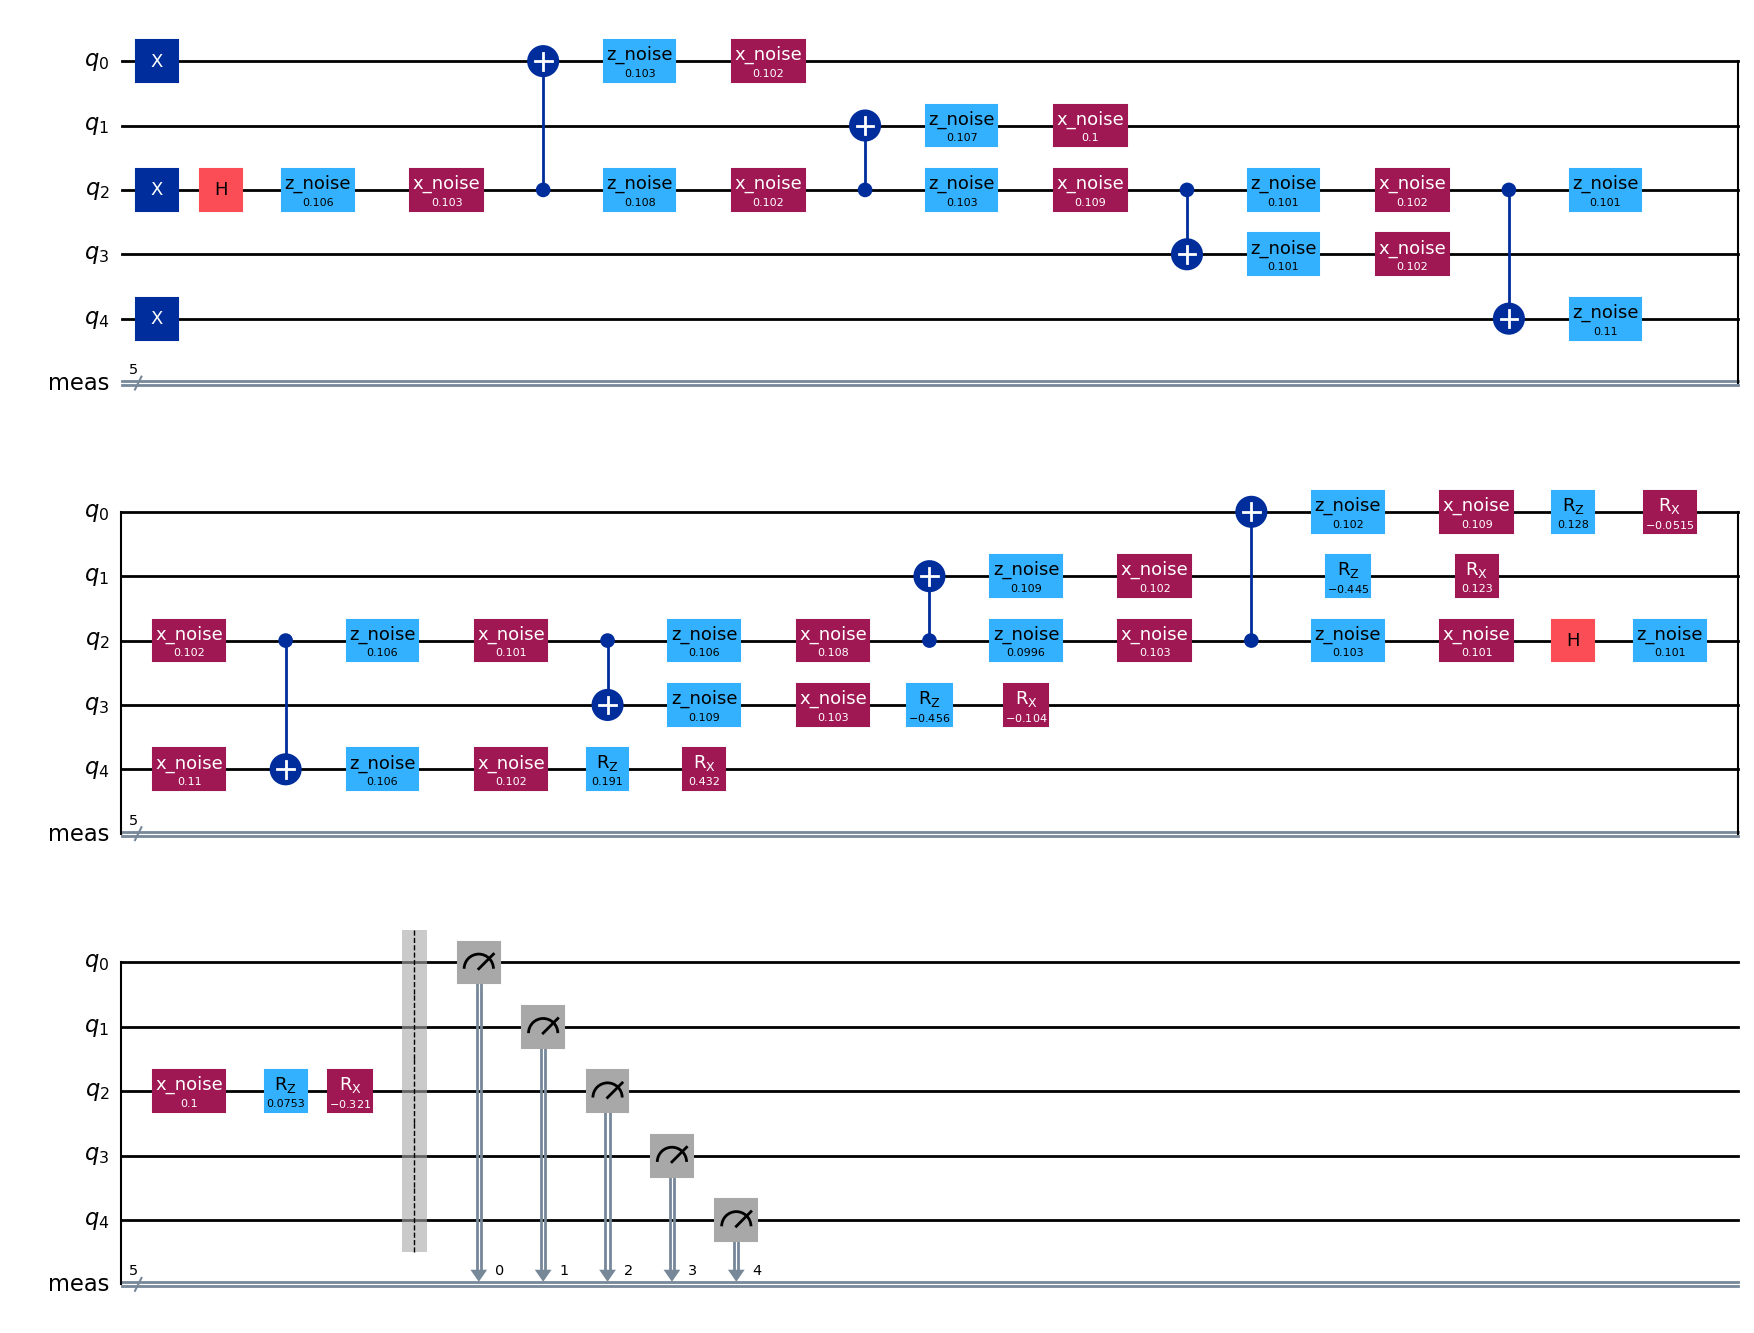

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

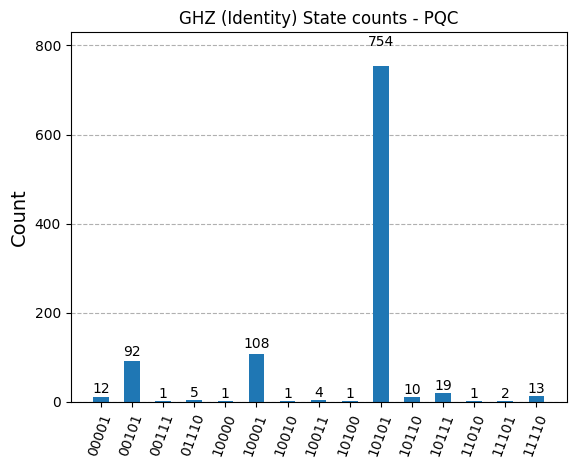

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

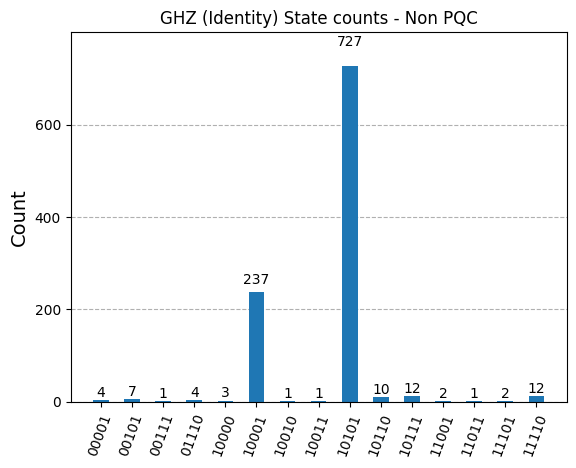

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')